In [12]:
from utils import get_conn
from pyathena.util import as_pandas
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import numpy as np
import pandas as pd
import functools as ft
from typing import List, Set
import pandas as pd
from sodapy import Socrata
import gensim
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from visdata import summary_table, note_lengths, icd_summary
from utils import tree_to_nx
from icd9.icd9 import ICD9
from colour import Color
import networkx as nx
import matplotlib.pyplot as plt

## Read in Data

In [2]:
with get_conn() as CONN:
    cursor = CONN.cursor()
    # read in a random sample of notes
    icd_codes = as_pandas(cursor.execute("select icd9_code from mimiciii.diagnoses_icd"))

In [4]:
samp_df.head()

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,text
0,1553951,22277,186839.0,2138-07-27,2138-07-27 14:26:00,2138-07-27 15:04:00,Nursing/other,Report,14695.0,None,77 yr old pt with hyponatremaia prob d/t polyd...
1,1799729,8555,139314.0,2200-12-07,2200-12-07 14:10:00,2200-12-07 14:11:00,Nursing/other,Report,19048.0,None,Neonatology-[** 1**] Physical Exam\n\n[**Known...
2,612251,98666,127829.0,2151-11-30,2151-11-30 05:13:00,2151-11-30 06:29:12,Nursing,Nursing Progress Note,21108.0,None,"Pneumonia, aspiration\n Assessment:\n LS w..."
3,614534,40610,158053.0,2126-12-22,2126-12-22 15:48:00,2126-12-22 18:22:34,Nursing,Nursing Progress Note,18147.0,None,Events: Not tolerating percussion therapy on t...
4,1961549,20681,176355.0,2136-06-12,2136-06-12 02:44:00,2136-06-12 03:06:00,Nursing/other,Report,17335.0,None,Neonatology Attending\n36-6/7 week GA male adm...


## Network Vis

In [8]:
tree = ICD9("icd9/codes.json")
G = tree_to_nx(tree.children[0].children[0])

In [40]:
blue = Color("blue")
red = Color("red")
degrees = dict(G.degree)
grad = list(blue.range_to(red, (max(degrees.values())) + 1))
icd_colors = {icd: grad[d] for icd, d in degrees.items()}

In [41]:
icd_df = pd.DataFrame(data={"icd": list(icd_colors.keys()), "colors": list(icd_colors.values())})
icd_df = icd_df.set_index("icd")
icd_df = icd_df.reindex(G.nodes())

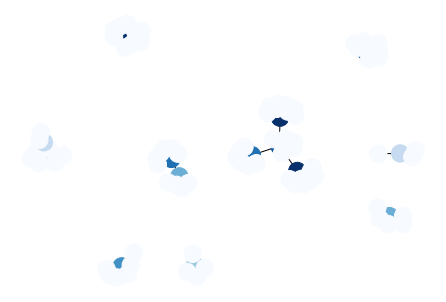

In [47]:
nx.draw(G, with_labels=False, node_color=list(degrees.values()), cmap=plt.cm.Blues)

## Summative Visualizations

### ICD Summary Table

In [16]:
#icds = [c for c in icd_codes["icd9_code"] if c]
icd_table = icd_summary(icd_codes, tree)

KeyboardInterrupt: 

In [ ]:
icd_table

### Category Counts

In [29]:
ccounts_query = "select category, count(row_id) from mimiciii.noteevents group by category;"
ccounts_df = as_pandas(cursor.execute(ccounts_query))
ccounts_df.columns = ["category", "count"]
ccounts_df = ccounts_df.sort_values("count", ascending=False)

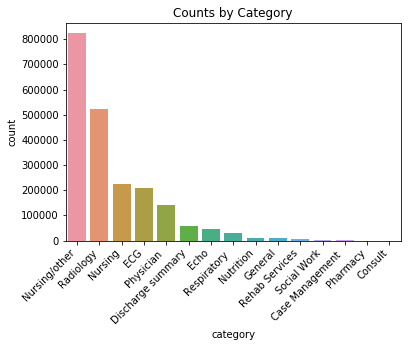

In [36]:
ax = sns.barplot(x="category", y="count", data=ccounts_df)
ax.set_title("Counts by Category")
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.show()

### Distribution of Redundancy in Nursing/other Category

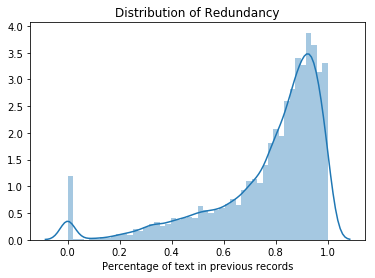

In [123]:
ax = sns.distplot(cat_df["scores"])
ax.set_title("Distribution of Redundancy")
ax.set_xlabel("Percentage of text in previous records")
plt.show()

### Distribution on Word Counts in Notes

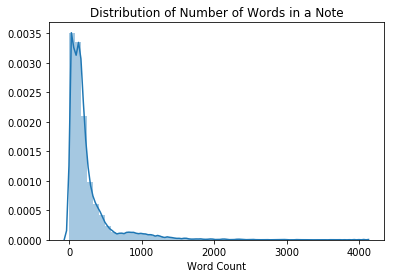

In [122]:
ax = sns.distplot(samp_df["processed"].apply(lambda x: len(x)))
ax.set_title("Distribution of Number of Words in a Note")
ax.set_xlabel("Word Count")
plt.show()

## Join with DRG Codes

In [48]:
drg_query: str = f"select * from mimiciii.drgcodes"
drg_df = as_pandas(cursor.execute(drg_query))
drg_df["hadm_id"] = drg_df["hadm_id"].apply(lambda x: float(x))
sub_drg_df = drg_df.loc[:,["hadm_id", "drg_type", "drg_code", "description"]]
sub_drg_df.columns = ["hadm_id", "drg_type", "drg_code", "drg_description"]
samp_drg_df = samp_df.merge(sub_drg_df, on="hadm_id", how="left")

## Get document embeddings

In [82]:
# generate gensim tokens
def read_corpus(docs: List[str]):
    for i, doc in enumerate(docs):
        tokens = gensim.utils.simple_preprocess(doc)
        yield gensim.models.doc2vec.TaggedDocument(tokens, [i])
        
train_corpus = list(read_corpus(samp_drg_df["text"].tolist()))

In [65]:
# train doc2vec model
doc2vec = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
doc2vec.build_vocab(train_corpus)
doc2vec.train(train_corpus, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

In [91]:
# generate embeddings
samp_drg_df["embeddings"] = samp_drg_df["processed"].apply(doc2vec.infer_vector)

## Forecast DRG Codes with Logistic Regression

In [113]:
# train logistic regression
labels = LabelEncoder().fit_transform(samp_drg_df["drg_code"].tolist())
X_train, X_test, y_train, y_test = train_test_split(samp_drg_df["embeddings"].tolist(), \
                                                    labels, \
                                                    test_size=0.2)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


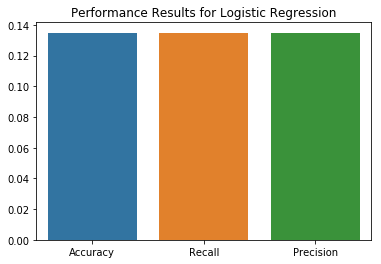

In [121]:
# measure performance
y_preds = clf.predict(X_test)
acc = accuracy_score(y_test, y_preds)
rec = recall_score(y_test, y_preds, average='micro')
prec = precision_score(y_test, y_preds, average='micro')
x = ["Accuracy", "Recall", "Precision"]
y = [acc, rec, prec]
ax = sns.barplot(x=x, y=y)
ax.set_title("Performance Results for Logistic Regression")
plt.show()

## Luigi Pipelining
`Collection -> Preprocessing -> Training -> Evaluation`

## Future Work

- Determine between pursuing redundancy, patient outcomes, or billing
- Build Luigi pipeline
- Better document embedding
- Better model selection

## Expore Medicare Data

In [21]:
client = Socrata("data.cms.gov", None)

In [22]:
# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("fs4p-t5eq", limit=2000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)